In [1]:
import os
import argparse
import hashlib
import json
from tqdm import tqdm

import nibabel
import numpy as np
import torch
from torch.nn.functional import interpolate

import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

EXCLUDED_CASES = []#[23, 68, 125, 133, 15, 37]
MAX_ID = 210
MEAN_VAL = 101.0
STDDEV_VAL = 76.9
MIN_CLIP_VAL = -79.0
MAX_CLIP_VAL = 304.0
TARGET_SPACING = [1.6, 1.2, 1.2]
TARGET_SHAPE = [128, 128, 128]
class Stats:
    def __init__(self):
        self.mean = []
        self.std = []
        self.d = []
        self.h = []
        self.w = []

    def append(self, mean, std, d, h, w):
        self.mean.append(mean)
        self.std.append(std)
        self.d.append(d)
        self.h.append(h)
        self.w.append(w)

    def get_string(self):
        self.mean = np.median(np.array(self.mean))
        self.std = np.median(np.array(self.std))
        self.d = np.median(np.array(self.d))
        self.h = np.median(np.array(self.h))
        self.w = np.median(np.array(self.w))
        return f"Mean value: {self.mean}, std: {self.std}, d: {self.d}, h: {self.h}, w: {self.w}"


class Preprocessor:
    def __init__(self, args):
        self.mean = MEAN_VAL
        self.std = STDDEV_VAL
        self.min_val = MIN_CLIP_VAL
        self.max_val = MAX_CLIP_VAL
        self.results_dir = args.results_dir
        self.data_dir = args.data_dir
        self.target_spacing = TARGET_SPACING
        self.stats = Stats()

    def preprocess_dataset(self):
        os.makedirs(self.results_dir, exist_ok=True)
        print(f"Preprocessing {self.data_dir}")
        for case in sorted([f for f in os.listdir(self.data_dir) if "case" in f]):
            case_id = int(case.split("_")[1])
            if case_id in EXCLUDED_CASES or case_id >= MAX_ID:
                print("Case {}. Skipped.".format(case_id))
                continue
            image, label, image_spacings = self.load_pair(case)
            image, label = self.preprocess_case(image, label, image_spacings)
            image, label = self.pad_to_min_shape(image, label)
            self.save(image, label, case)
        print(self.stats.get_string())

    def preprocess_case(self, image, label, image_spacings):
        image, label = self.resample3d(image, label, image_spacings)
        image = self.normalize_intensity(image.copy())
        return image, label

    @staticmethod
    def pad_to_min_shape(image, label):
        current_shape = image.shape[1:]
        bounds = [max(0, TARGET_SHAPE[i] - current_shape[i]) for i in range(3)]
        paddings = [(0, 0)]
        paddings.extend([(bounds[i] // 2, bounds[i] - bounds[i] // 2) for i in range(3)])
        return np.pad(image, paddings, mode="edge"), np.pad(label, paddings, mode="edge")

    def load_pair(self, case: str):
        image = nibabel.load(os.path.join(self.data_dir, case, "imaging.nii.gz"))
        label = nibabel.load(os.path.join(self.data_dir, case, "segmentation.nii.gz"))
        image_spacings = image.header["pixdim"][1:4].tolist()
        image, label = image.get_fdata().astype(np.float32), label.get_fdata().astype(np.uint8)
        image, label = np.expand_dims(image, 0), np.expand_dims(label, 0)
        return image, label, image_spacings

    def resample3d(self, image, label, image_spacings):
        if image_spacings != self.target_spacing:
            spc_arr = np.array(image_spacings)
            targ_arr = np.array(self.target_spacing)
            shp_arr = np.array(image.shape[1:])
            new_shape = (spc_arr / targ_arr * shp_arr).astype(int).tolist()

            image = interpolate(torch.from_numpy(np.expand_dims(image, 0)),
                                size=new_shape, mode='trilinear', align_corners=True)
            label = interpolate(torch.from_numpy(np.expand_dims(label, 0)), size=new_shape, mode='nearest')
            image = np.squeeze(image.numpy(), 0)
            label = np.squeeze(label.numpy(), 0)
        return image, label

    def normalize_intensity(self, image: np.array):
        image = np.clip(image, self.min_val, self.max_val)
        image = (image - self.mean) / self.std
        return image

    def save(self, image, label, case: str):
        image = image.astype(np.float32)
        label = label.astype(np.uint8)
        mean, std = np.round(np.mean(image, (1, 2, 3)), 2), np.round(np.std(image, (1, 2, 3)), 2)
        print(f"Saving {case} shape {image.shape} mean {mean} std {std}")
        self.stats.append(mean, std, image.shape[1], image.shape[2], image.shape[3])
        np.save(os.path.join(self.results_dir, f"{case}_x.npy"), image, allow_pickle=False)
        np.save(os.path.join(self.results_dir, f"{case}_y.npy"), label, allow_pickle=False)

In [6]:

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle("Center slices for EPI image") 

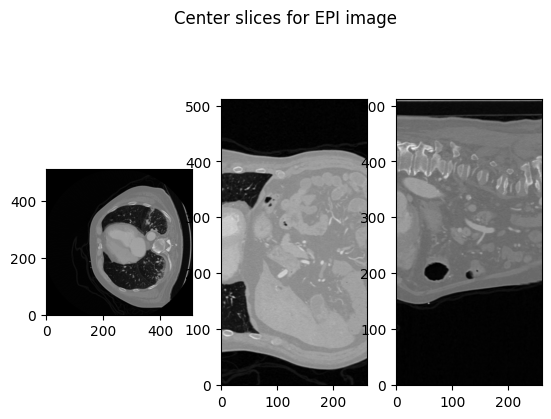

In [11]:
image = nibabel.load(os.path.join("/data/kits19/data/case_00002", "imaging.nii.gz"))
image = image.get_fdata()
shapes = image.shape
shape_0 = shapes[0]//2
shape_1 = shapes[1]//2
shape_2 = shapes[2]//2
slices = [image[shape_0, :, :], image[:, shape_1, :], image[:, :, shape_2]]
show_slices(slices)

In [1]:
if 10 == None:
    print("x")